In [32]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

exp_inc_dosage = {0: 0.01, 1:0.026, 2:0.068, 3: 0.176, 4: 0.457, 5: 1.188, 6:3.089, 21: 5}
exp_dec_dosage = {0: 3.089, 1: 1.188, 2: 0.457, 3:0.176, 4:0.068, 5:0.026, 6:0.01, 21:5}
constant_dosage = {0: 0.714, 1: 0.714, 2: 0.714, 3: 0.714, 4: 0.714, 5: 0.714, 6: 0.714, 21: 5}
bolus21_dosage = {0: 5, 21: 5}
bolus28_dosage = {0: 5, 28: 5}
exp_inc_2wk_dosage = {0: 0.01, 2:0.026, 4:0.068, 6: 0.176, 8: 0.457, 10: 1.188, 12:3.089, 28: 5}
bolus_prime_exp_inc_boost_dosage = {0: 5, 28: 0.01, 30:0.026, 32:0.068, 34: 0.176, 36: 0.457, 38: 1.188, 40:3.089,}
exp_inc_prime_and_boost_dosage = {0: 0.01, 2:0.026, 4:0.068, 6: 0.176, 8: 0.457, 10: 1.188, 12:3.089, 28: 0.01, 30:0.026, 32:0.068, 34: 0.176, 36: 0.457, 38: 1.188, 40:3.089,}

def convert_to_tensor(dosage):
    arr = []
    for i in range(0, 41):
        arr.append(float(dosage.get(i, 0)))
    return torch.tensor(arr)

dosage_dict = {"Exp-inc": convert_to_tensor(exp_inc_dosage), "Exp-dec":convert_to_tensor(exp_dec_dosage), 
            "Constant": convert_to_tensor(constant_dosage), "Bolus": convert_to_tensor(bolus21_dosage), 
            "Boost d28": convert_to_tensor(bolus28_dosage), "Exp Increase 2wk": convert_to_tensor(exp_inc_2wk_dosage), 
            "Exp Boost": convert_to_tensor(bolus_prime_exp_inc_boost_dosage), "Exp Prime/Boost": convert_to_tensor(exp_inc_prime_and_boost_dosage)}

class Data(torch.utils.data.Dataset):
    def __init__(self, dosages, results):
        self.dosages = dosages
        self.results = results
    def __len__(self):
        return len(self.results)
    def __getitem__(self, index):
        dosage = self.dosages[index]
        result = self.results[index]
        return dosage, result

data = pd.read_csv("2024-10-27 Tam 2016 Data.csv")
data = data.replace('-', np.nan)
data = data.replace("Exp Increase 1wk", "Exp-inc")
data["Binding"] = data["Binding"].astype("float32")
data["Time"] = data["Time"].transform(lambda x: int(x[3:]))
data = data.drop(data[data["Time"]>56].index)
data = data.reset_index(drop=True)
data["Subject"] = data["Subject"].transform(lambda x: int(x[6:]))

for i in range(len(data)):
    if math.isnan(data.iloc[i, data.columns.get_loc("Binding")]):
        time = int(data.iloc[i, data.columns.get_loc("Time")])
        dosing = str(data.iloc[i, data.columns.get_loc("Vaccine Scheme")])
        mean = data[(data["Time"]==time) & (data["Vaccine Scheme"]==dosing)]["Binding"].mean()
        data.loc[i, ["Binding"]] = mean

dosages = data.groupby("Subject")["Vaccine Scheme"].nth(0)
dosages = [dosage_dict[x] for x in dosages.to_list()]
results = data.groupby("Subject")["Binding"].apply(list)
results = [torch.tensor(x) for x in results.to_list()]

class RegressionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(torch.nn.LazyLinear(64), torch.nn.ReLU(), torch.nn.LazyLinear(8))

    def forward(self, x):
        return self.net(x)

epoch 1, loss 15690.572320556641
epoch 2, loss 15628.428088378907
epoch 3, loss 15512.216259765624
epoch 4, loss 15269.165618896484
epoch 5, loss 14763.6021484375
epoch 6, loss 13809.884564208984
epoch 7, loss 12332.045919799804
epoch 8, loss 10628.476266479493
epoch 9, loss 9117.331280517577
epoch 10, loss 7893.649908447265
epoch 11, loss 6896.666821289063
epoch 12, loss 6092.2897277832035
epoch 13, loss 5475.091613769531
epoch 14, loss 5025.244876098633
epoch 15, loss 4713.153036499023
epoch 16, loss 4478.85993347168
epoch 17, loss 4287.288650512695
epoch 18, loss 4131.802676391601
epoch 19, loss 3989.77626953125
epoch 20, loss 3860.8063415527345
epoch 21, loss 3743.3582275390627
epoch 22, loss 3632.0401306152344
epoch 23, loss 3527.2887329101563
epoch 24, loss 3431.561877441406
epoch 25, loss 3341.82626953125
epoch 26, loss 3254.3717193603516
epoch 27, loss 3178.425360107422
epoch 28, loss 3105.232470703125
epoch 29, loss 3039.732620239258
epoch 30, loss 2984.922769165039
epoch 31, 

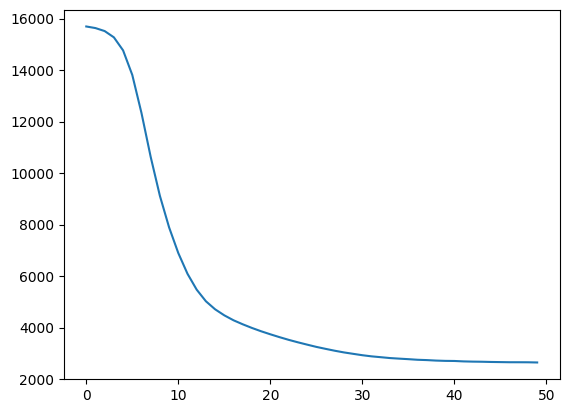

In [34]:
def train(model, data, epochs, lr):
    lossFunction = torch.nn.MSELoss(reduction="mean")
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    prevLoss = float("inf")

    losses = []
    for i in range(1, epochs+1):
        epoch_loss = 0
        for batch in data:
            features, labels = batch
            optimizer.zero_grad()
            y_pred = model(features)
            
            loss = lossFunction(y_pred, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        losses.append(epoch_loss/len(data))
        print('epoch {}, loss {}'.format(i, epoch_loss/len(data)))

        if(epoch_loss>prevLoss):
            print("Stopped early on epoch {}".format(i))
            break
        prevLoss = epoch_loss
    
    plt.plot(range(len(losses)), losses)
    plt.show()
    

model = RegressionModel()

dataset = Data(dosages, results)
batch_size = 16
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

train(model=model, data=dataloader, epochs=50, lr=0.0005)
torch.save(model, "model.pt")


128.78021240234375


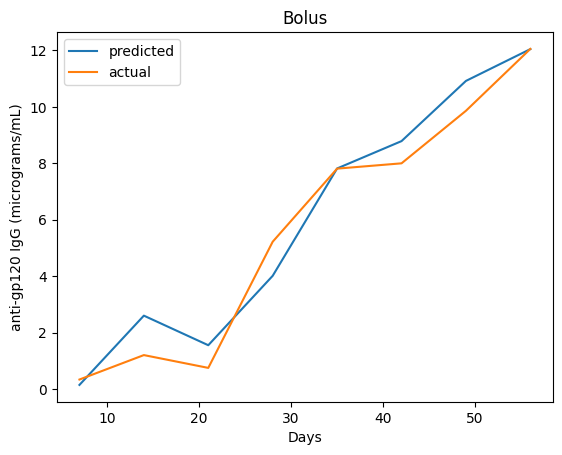

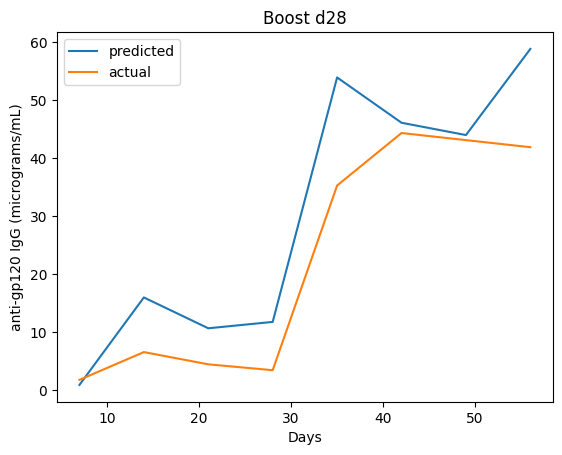

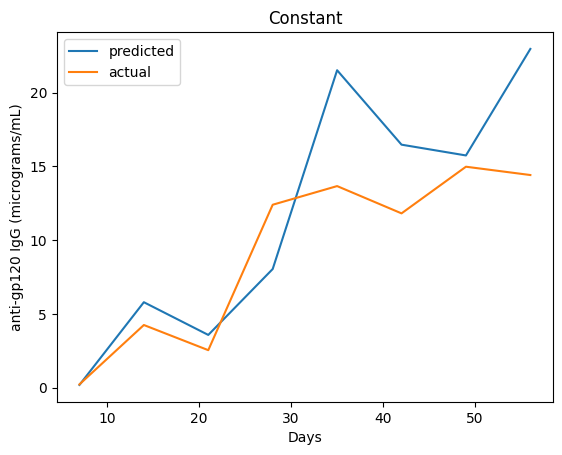

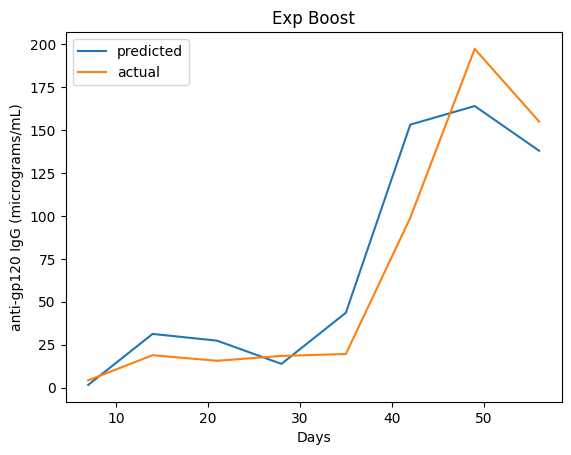

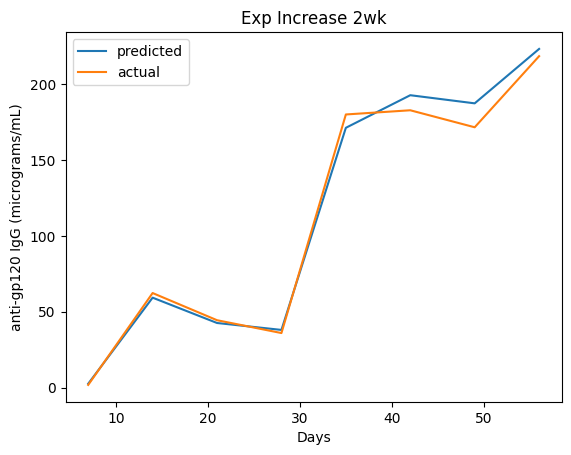

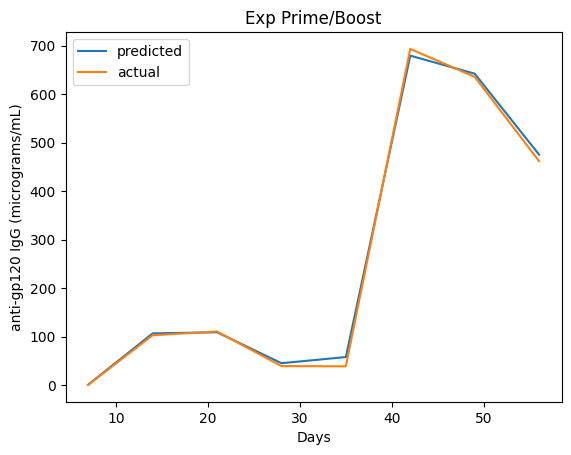

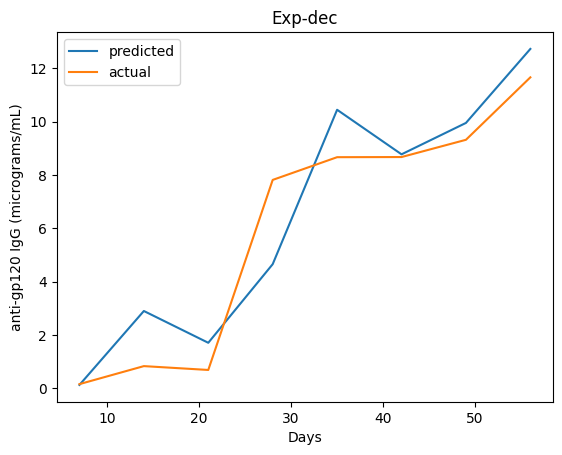

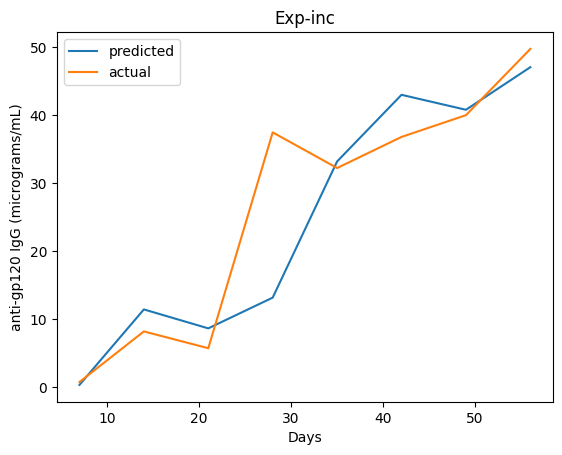

In [35]:
model = torch.load("model.pt", weights_only=False)
model.eval()

means = data.groupby(["Vaccine Scheme", "Time"])["Binding"].mean()
dosages = []
dosage_names = []
results = []
result = []
for index, value in means.items():
    if index[1]==7:
        dosages.append(dosage_dict[index[0]])
        dosage_names.append(index[0])
        results.append(torch.tensor(result))
        result = []
    result.append(value)
results.append(torch.tensor(result))
results = results[1:]
test_data = Data(dosages, results)

test_data = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=False)

features, labels = next(iter(test_data))
prediction = model(features)

lossFunction = torch.nn.MSELoss(reduction="mean")
loss = lossFunction(prediction, labels)
print(loss.item())
for i, pred in enumerate(prediction):
    plt.plot(range(7, 63, 7), pred.tolist(), label="predicted")
    plt.plot(range(7, 63, 7), labels[i].tolist(), label="actual")
    ax = plt.gca()
    plt.xlabel("Days")
    plt.ylabel("anti-gp120 IgG (micrograms/mL)")
    plt.title(dosage_names[i])   
    plt.legend()
    plt.show()

In [36]:
test_dosage1 = {0: 1.25, 1: 1.25, 2: 1.25, 3:25, 4:1.25, 5:1.25, 6:1.25, 21: 1.25}
test_dosage2 = {0: 0.714, 2:0.714, 4:0.714, 6: 0.714, 8: 0.714, 10: 0.714, 12:0.714, 28: 0.714, 30:0.714, 32:0.714, 34: 0.714, 36: 0.714, 38: 0.714, 40:0.714}
test_dosage3 = {0: 3.089, 2:1.188, 4:0.457, 6: 0.176, 8: 0.068, 10: 0.026, 12:0.01, 28: 3.089, 30:1.188, 32:0.457, 34: 0.176, 36: 0.068, 38: 0.026, 40:0.01}
test_dosage4 = {0: 2, 28: 8}

test_prediction = model(convert_to_tensor(test_dosage1))
test_prediction2 = model(convert_to_tensor(test_dosage2))
test_prediction3 = model(convert_to_tensor(test_dosage3))
test_prediction4 = model(convert_to_tensor(test_dosage4))
print(test_prediction)
print(test_prediction2)
print(test_prediction3)
print(test_prediction4)

tensor([ 1.4341,  7.6594,  5.9483,  5.7158, 18.2101, 27.8398, 27.7512, 28.4029],
       grad_fn=<ViewBackward0>)
tensor([  0.9823,  34.4586,  31.4592,  17.0203,  45.8093, 180.9205, 175.2627,
        146.3035], grad_fn=<ViewBackward0>)
tensor([ 0.7530, 12.5937,  8.4478,  8.9044, 39.9774, 37.8720, 36.7192, 46.7683],
       grad_fn=<ViewBackward0>)
tensor([  1.2696,  29.8204,  19.8108,  22.7298, 104.8665,  83.4036,  73.9504,
        106.7746], grad_fn=<ViewBackward0>)
